# import

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import glob
import datetime as dt
import tqdm
import json
import matplotlib.pyplot as plt
import numpy as np
import sys, os

sys.path.insert(0, os.path.abspath('../src/'))
from model.vgg19 import VGG19
from model.ViT import VisionTransformer
from model.augmentation import aug_process
from dataloader import aug_dataloader

# mixed precision

In [2]:
is_mixed = True

In [3]:
if is_mixed:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


# model type

In [4]:
model_type = 'EfficientNet'

# file path

In [5]:
json_open = open('../config.json', 'r')
config = json.load(json_open)

In [6]:
dataset_path = f'{config["filepath"]["dataset"]}'
partitions_path = f'{config["filepath"]["partitions"]}'
output_path = f'{config["filepath"]["output"]}/01'
file_name = f"{model_type}_{config['data']['img_size']}_keras"
log_dir = f"{output_path}/logs/{file_name}"

os.makedirs(log_dir, exist_ok=True)

In [7]:
test_txt_path_list = glob.glob(f"{partitions_path}/Test*")
train_txt_path_list = glob.glob(f"{partitions_path}/Train*")
class_name_path = f"{partitions_path}/ClassName.txt"

# label to index

In [8]:
f = open(class_name_path, 'r')
label_name_list = f.readlines()
label_name_list = list(map(lambda tmp_path: tmp_path[:-1].split('/', 2)[2], label_name_list))
f.close()
label_to_index = dict((name, index) for index, name in enumerate(label_name_list))

# text to path list

In [9]:
def txt_to_path(txt_path_list):
    path_list = []
    for path in txt_path_list:
        f = open(path, 'r')
        path_list+=f.readlines()
        f.close()
    
    path_list = list(map(lambda tmp_path: dataset_path+tmp_path[:-1], path_list))#.remove(config["data"]["exclude_list"])
    path_list = sorted(list(set(path_list)-set(config["data"]["exclude_list"])))
    label_list = list(map(lambda tmp_path: label_to_index[tmp_path.split('/', 6)[6].rsplit('/', 1)[0]], path_list))
    return path_list, label_list

In [10]:
img_path_list, label_list = txt_to_path(train_txt_path_list)

In [11]:
train_img_path_list, val_img_path_list,\
train_label_list, val_label_list = train_test_split(img_path_list, label_list,
                                                    test_size=0.2, random_state=0)
test_img_path_list, test_label_list = txt_to_path(test_txt_path_list)

In [12]:
tmp_dataloader = aug_dataloader(config['data']['batch_size'], config['data']['img_size'],)
train_ds = tmp_dataloader(train_img_path_list, train_label_list, shuffle_buffer=100)
val_ds = tmp_dataloader(val_img_path_list, val_label_list, train=False, shuffle=False)

# def model

In [13]:
strategy = tf.distribute.MirroredStrategy()
num_classes = len(label_to_index)+1
with strategy.scope():
    if model_type=='vgg19':
        model = VGG19(num_classes, img_size=config['data']['img_size'],)
    if model_type=='ViT':
        model = VisionTransformer(num_classes=num_classes, img_size=config['data']['img_size'])
    if model_type=='EfficientNet':
        model = tf.keras.applications.EfficientNetB3(classes=num_classes, weights=None,
                                                     input_shape=(config['data']['img_size'], config['data']['img_size'], 3))
    aug_model = aug_process(config['data']['img_size'])
    
    loss_obj = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
    def calc_loss(target_y, predicted_y):
        return tf.math.reduce_mean(loss_obj(target_y, predicted_y))
    
    acc_func = tf.keras.metrics.SparseCategoricalAccuracy()
    def calc_acc(target_y, predicted_y):
        return tf.math.reduce_mean(acc_func(target_y, predicted_y))
    
optimizer = tfa.optimizers.RectifiedAdam(lr=1e-3, clipnorm=0.01)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy', metrics=['acc'],)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

# train

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


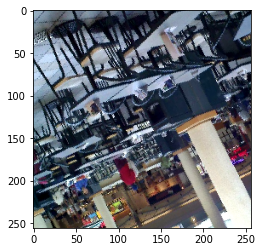

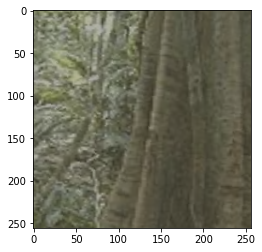

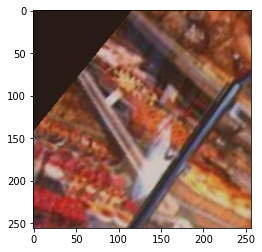

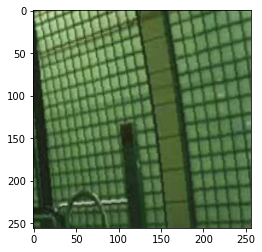

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


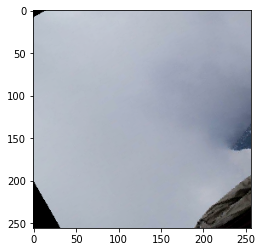

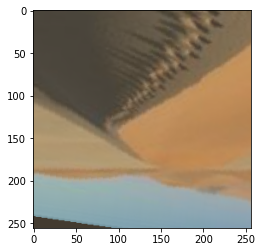

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


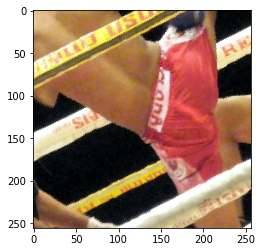

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


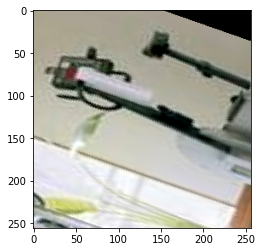

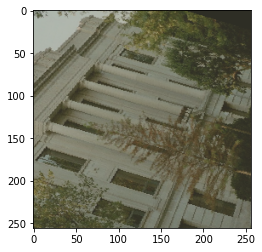

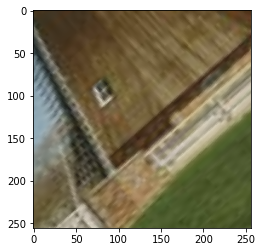

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


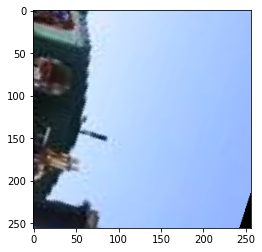

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


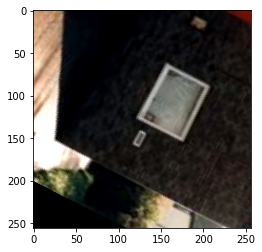

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


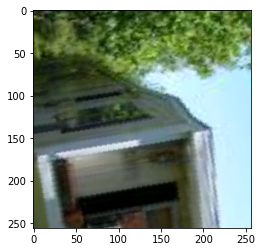

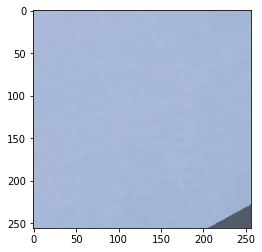

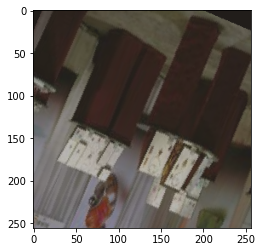

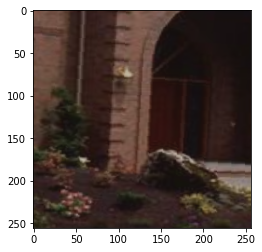

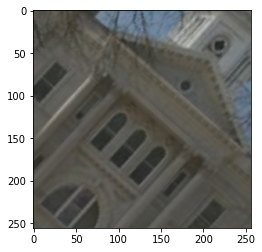

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


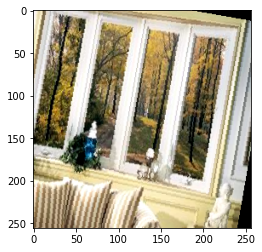

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


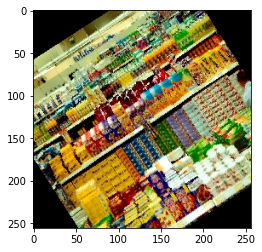

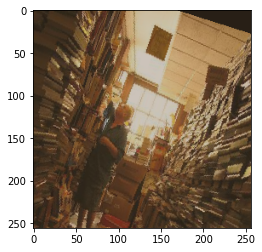

In [14]:
i=0
for img, label in train_ds:
    plt.imshow(np.float32(img[0].numpy()))
    plt.show()
    i+=1
    if i==20:
        
        break